In [1]:
# %%
import os
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Masking
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow.keras.backend as K
import time

# %%
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# %%
#### Change inputs
modelID = '93js'
## noaa stations following same order of the outputs
NOAAstations = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

#### Define paths and load data
# pathData = Path(r'../../../data/random_split')
pathData = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/inputs/random_split')
# pathColSample = pathData.parent
pathColSample = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
X_train_file = 'X_train_standardScaled_allInputs_augmentedAllX50_def.npy'
Y_train_file = 'y_train_augmentedAllX50_def.npy'
X_test_file = 'X_test_standardScaled_allInputs_augmentedAllX50_def.npy'
Y_test_file = 'y_test_augmentedAllX50_def.npy'

#### some hyperparameters
batch_size = 100
epochs = 850
fold = 1 ## no cross validation


/home/tacuevas/miniconda3/envs/tf2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-02 10:16:03.121426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 10:16:04.122849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tacuevas/miniconda3/envs/tf2/lib/
2024-01-02 10:16:04.122975: W tensorflow/compiler/xla/stream_executor/platform

In [2]:
#### path to store outputs
#pathOut0 = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/81')
pathOut = Path(f'../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/{modelID}')
#pathOut0 = pathOut0/st

#### class to save best model
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, pathout, fold, modelID):
        super(CustomCallback, self).__init__()
        self.pathout = pathout
        self.fold = fold
        self.modelID = modelID
        self.previous_val_loss = float('inf')  # Initialize with a high value
        self.best_epoch = None
        self.best_model = None
    
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.previous_val_loss:
            self.model.save(self.pathout / f'bestModel_{self.modelID}_noVal.tf')
            self.previous_val_loss = current_val_loss
            self.best_epoch = epoch
            self.best_model = self.model
            with open(self.pathout / f'best_model_noVal.txt', 'a') as fout:
                fout.write(f'Best model saved for fold {self.fold}: epoch {self.best_epoch}, val_loss: {current_val_loss:0.3f}\n')

#### load data
X_train = np.load(pathData/X_train_file)
y_train = np.load(pathData/Y_train_file)
X_test = np.load(pathData/X_test_file)
y_test = np.load(pathData/Y_test_file)

#### pathout
#pathOut = pathOut0/st

columns_sample = pd.read_csv(pathColSample/'dct_tracksAll_batch02_lengthCorr_tides_resampled_SAMPLE.csv', index_col = 0)

## inputs
cols = ['wind_speed', 'pressure', 'rad_to_max_ws', 'forward_speed_u', 'forward_speed_v',
            'dist_to_duck', 'Duck', 'dist_to_oregon', 'Oregon', 'dist_to_hatteras', 'Hatteras', 'dist_to_beaufort', 'Beaufort', 'dist_to_wilmington', 'Wilmington', 'dist_to_wrightsville', 'Wrightsville', 
            'wind_speed_fft', 'pressure_fft', 'rad_to_max_ws_fft',
            'forward_speed_u_fft', 'forward_speed_v_fft']

In [3]:
## extract inputs idx from the full input array
idx_cols = [list(columns_sample).index(x) for x in cols]
X_train = X_train[:, :, idx_cols]
X_test = X_test[:, :, idx_cols]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 235, 22)           0         
                                                                 
 conv1d (Conv1D)             (None, 233, 16)           1072      
                                                                 
 batch_normalization (BatchN  (None, 233, 16)          64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 116, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 114, 32)           1568      
                                                                 
 batch_normalization_1 (Batc  (None, 114, 32)          1

2024-01-02 10:16:13.594146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 10:16:14.916021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4356 MB memory:  -> device: 0, name: Quadro P2000, pci bus id: 0000:5b:00.0, compute capability: 6.1
2024-01-02 10:16:14.916823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3685 MB memory:  -> device: 1, name: Quadro P2000, pci bus id: 0000:9e:00.0, compute capability: 6.1


 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 27, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 64)                110656    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (

2024-01-02 10:16:21.757404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-01-02 10:16:22.103069: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 10:16:22.602491: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcf0400c7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 10:16:22.602585: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-01-02 10:16:22.602611: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro P2000, Compute Capability 6.1
2024-01-02 10:16:22.617792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 10:16:22.701148: I tensorflow/tsl/platform/default/subprocess.cc

786/786 [==============================] - 20s 19ms/step - loss: 0.2184 - mse: 0.5011 - mae: 0.5181 - rmse: 0.7079
Epoch 2/850
786/786 [==============================] - 15s 19ms/step - loss: 0.1343 - mse: 0.2979 - mae: 0.3830 - rmse: 0.5458
Epoch 3/850
786/786 [==============================] - 15s 19ms/step - loss: 0.1094 - mse: 0.2397 - mae: 0.3381 - rmse: 0.4895
Epoch 4/850
786/786 [==============================] - 14s 18ms/step - loss: 0.0936 - mse: 0.2013 - mae: 0.3080 - rmse: 0.4486
Epoch 5/850
786/786 [==============================] - 14s 18ms/step - loss: 0.0819 - mse: 0.1741 - mae: 0.2843 - rmse: 0.4173
Epoch 6/850
786/786 [==============================] - 14s 18ms/step - loss: 0.0742 - mse: 0.1568 - mae: 0.2685 - rmse: 0.3960
Epoch 7/850
786/786 [==============================] - 14s 18ms/step - loss: 0.0687 - mse: 0.1446 - mae: 0.2573 - rmse: 0.3803
Epoch 8/850
786/786 [==============================] - 15s 19ms/step - loss: 0.0647 - mse: 0.1357 - mae: 0.2492 - rmse: 0.3

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93js/bestModel_93js_nonVal.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93js/bestModel_93js_nonVal.tf/assets


Training time: 3.381 hrs
434/434 [==============================] - 3s 5ms/step


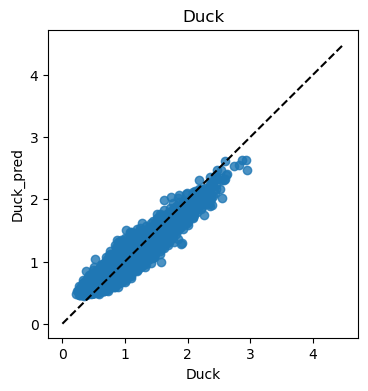

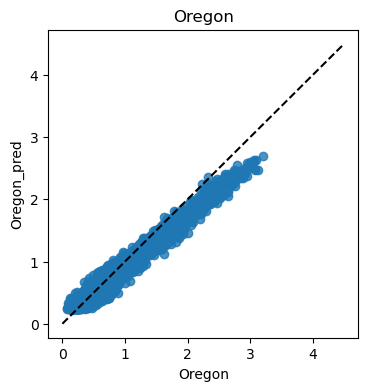

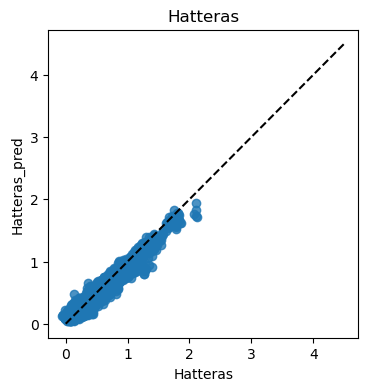

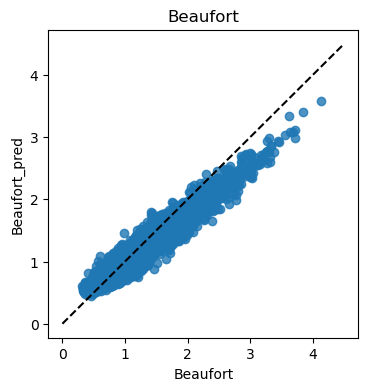

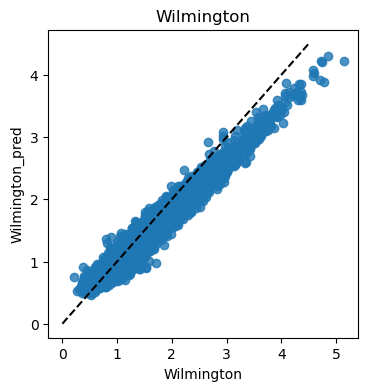

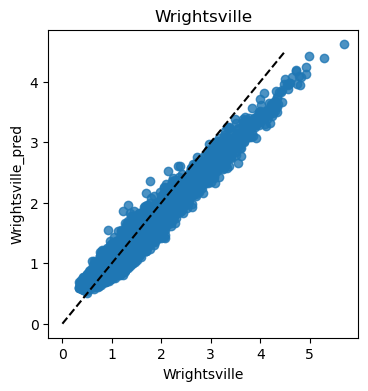

In [4]:
try:
    os.mkdir(pathOut)
except:
    pass

#### Define model
model = Sequential([
                Masking(-9999, input_shape=(X_train.shape[1:])),
                Conv1D(16, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(32, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(64, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.2),
                Dense(6, activation='relu'),
            ])

optimizer = RMSprop(learning_rate = 1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), 
                metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

#### train the model
t0 = time.time()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)
model.save(pathOut / f'bestModel_{modelID}_nonVal.tf')
print(f'Training time: {(time.time() - t0)/3600:0.3f} hrs')

####  predictions
predictions = model.predict(X_test)
dfPred = pd.DataFrame(predictions, columns = [f'{x}_pred' for x in NOAAstations])
dfTest = pd.DataFrame(y_test.reshape(y_test.shape[:2]), columns = NOAAstations)
dfAll = pd.concat([dfTest, dfPred], axis = 1)
dfAll.to_csv(pathOut/f'predTestSet_{modelID}.csv')

for i in range(6):
    fig, ax = plt.subplots(figsize = (4,4))
    sns.regplot(x = dfTest.iloc[:, i], y = dfPred.iloc[:, i], ax = ax, fit_reg = False)
    ax.plot(np.arange(0, 5, 0.5), np.arange(0, 5, 0.5), ls = '--', c = 'k')
    ax.set_title(f'{NOAAstations[i]}')
    fig.savefig(pathOut/f'predTestSet_{modelID}_{NOAAstations[i]}.png',
                dpi = 100, bbox_inches = 'tight')